# FETCH REWARDS TAKE-HOME EXERCISE

I completed this exercise based on Jupyter notebook. Hopefully, this would be a good try. 

In [26]:
#modules import

import os
import pandas as pd
from pandaserd import ERD
from sqlalchemy import create_engine



## Part 1

I created ERD with help of pandaserd module in Python (https://pypi.org/project/pandaserd/) and manually added some notes to it. 

ERD_RECEIPTS.png shows how it looks like. 

In [28]:
# read data
filelst=os.listdir("./")
for i in filelst:
    if i.endswith(".csv"):
        exec('{}=pd.read_csv(i)'.format(i.split(".")[0]))


AttributeError: module 'toggle_cell' has no attribute 'toggle_code'

In [3]:
# change variables that contain "date" to date data type in pandas
def change_date_type(df):
    for i in df.columns:
        if i.__contains__("DATE"):
            df[i]=df[i].astype("datetime64[ns]")
change_date_type(receipt_items)
change_date_type(receipts)
change_date_type(users)



In [4]:
# create ERD with Python
erd=ERD()
t_receipt=erd.add_table(receipts,'RECEIPT', bg_color='lightblue')
t_receipt_item=erd.add_table(receipt_items,"RECEIPT_ITEM",bg_color="lightblue")
t_users=erd.add_table(users,"USERS",bg_color="lightblue")
t_brands=erd.add_table(brands,"BRANDS",bg_color="lightblue")
erd.create_rel("USERS","RECEIPT",left_on="ID",right_on="USER_ID",left_cardinality="+",right_cardinality="*")
erd.create_rel("RECEIPT_ITEM","BRANDS",on='BARCODE',left_cardinality="*",right_cardinality="+")
erd.create_rel("RECEIPT","RECEIPT_ITEM",left_on="ID",right_on="REWARDS_RECEIPT_ID",left_cardinality="+",right_cardinality="*")
erd.create_rel("RECEIPT","BRANDS",left_on="STORE_NAME",right_on="NAME",left_cardinality="*",right_cardinality="+")
erd.create_rel("RECEIPT_ITEM","BRANDS",on="BRAND_CODE",left_cardinality="*",right_cardinality="+")
erd.write_to_file("output1.txt")

written to output1.txt; visit https://edotor.net/ to render ERD


## Part 2

I use SQLite for querying data from tables. 

I include SQL querys to five questions listed in second part below. 

For simple, I ran and tested SQL codes in Python with Pandas built-in SQLite connection. Just in case, I also put SQL query codes in 
sql_query.txt file.  

In [5]:
#create a sqlite database
engine = create_engine('sqlite://', echo=False)

In [6]:
#impoort CSV data to created sqlite3 connection above.
users.to_sql("USERS",con=engine)
receipts.to_sql("RECEIPTS",con=engine)
receipt_items.to_sql("RECEIPTS_ITEMS",con=engine)
brands.to_sql("BRANDS",con=engine)

406

Q: Which brand saw the most dollars spent in the month of June?


In [7]:
QUERY=''' 

SELECT STORE_NAME
FROM
(SELECT STORE_NAME,
STRFTIME('%m',DATE_SCANNED) AS month
FROM RECEIPTS
WHERE month='06'
GROUP BY STORE_NAME
ORDER BY TOTAL_SPENT DESC
LIMIT 1)




'''
engine.execute(QUERY).fetchall()

[('CHASE',)]

Q: Which user spent the most money in the month of August?


In [8]:
QUERY='''


SELECT USER_ID,MAX(Month_spent)
FROM
(SELECT USER_ID,SUM(TOTAL_SPENT) AS Month_spent,
STRFTIME('%m',DATE_SCANNED) AS month
FROM RECEIPTS
WHERE month='08'
GROUP BY USER_ID)



'''
engine.execute(QUERY).fetchall()


[('609ab37f7a2e8f2f95ae968f', 157719.27)]

Q: What user bought the most expensive item?


In [9]:
QUERY='''


SELECT USER_ID
FROM RECEIPTS_ITEMS t
LEFT JOIN RECEIPTS r ON t.REWARDS_RECEIPT_ID=r.ID
ORDER BY (TOTAL_FINAL_PRICE/QUANTITY_PURCHASED) DESC
LIMIT 1


'''
engine.execute(QUERY).fetchall()

[('617376b8a9619d488190e0b6',)]

Q: What is the name of the most expensive item purchased?

In [10]:
QUERY='''


SELECT DESCRIPTION
FROM RECEIPTS_ITEMS 
ORDER BY (TOTAL_FINAL_PRICE/QUANTITY_PURCHASED) DESC
LIMIT 1


'''

engine.execute(QUERY).fetchall()

[('Starbucks Iced Coffee Premium Coffee Beverage Unsweetened Blonde Roast Bottle 48 Oz 1 Ct',)]

Q: How many users scanned in each month?


In [11]:
QUERY='''


SELECT COUNT(*),month
FROM
(SELECT COUNT(DATE_SCANNED),
STRFTIME('%m',DATE_SCANNED) AS month
FROM RECEIPTS
GROUP BY month,USER_ID)
GROUP BY month


'''
engine.execute(QUERY).fetchall()

[(97, '01'),
 (87, '02'),
 (89, '03'),
 (90, '04'),
 (88, '05'),
 (88, '06'),
 (88, '07'),
 (88, '08'),
 (88, '09'),
 (91, '10'),
 (93, '11'),
 (98, '12')]

# Part 3

For this part, I tried to explore some small questions that may do help for business with Pandas and SQL tools. 

#### Two data quality issues

First, found a data quality issue that may influence later data analysis work. Almost 57% (as shown below)of brand codes in the receipts items is null, which makes harder to get information from Brands table. 

In [12]:
re_combine=pd.merge(receipt_items,receipts,left_on="REWARDS_RECEIPT_ID",right_on="ID",how="left")
re_combine["BRAND_CODE"].isnull().sum()/(len(re_combine["BRAND_CODE"]))

0.5702084206261776

And second data quality issue is related to data consistency issue in receipts_items table. For receipts which get non points("POINTS_EARNED), but "NON_POINT_EARNING_RECEIPT" shows FALSE. Like an example below: 

In [13]:
re_combine[["POINTS_EARNED","NON_POINT_EARNING_RECEIPT"]][:2]
# The example shows two items on same receipt. 

,POINTS_EARNED,NON_POINT_EARNING_RECEIPT
0,NaN,False
1,NaN,False


#### Some data analysis work

### How many items can get points based on users scanned receipts data?

In [14]:
1-re_combine["POINTS_EARNED"].isnull().sum()/len(re_combine["POINTS_EARNED"])

0.05258937168576239

From the results above, we can see that only 5% of items scanned can get points. 

### What is age group distribution of users?

<AxesSubplot:>

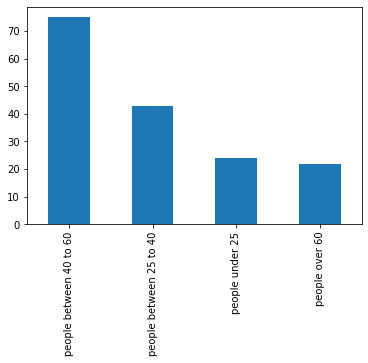

In [15]:
QUERY='''
SELECT strftime('%Y', 'now') - strftime('%Y', BIRTH_DATE) AS AGE
FROM USERS

'''
agetuple=engine.execute(QUERY).fetchall()
agelst=[]
for i in agetuple:
    agelst.append(i[0])
agelst
users_copy=users.copy()
users_copy["AGE"]=agelst
labels=["people under 25","people between 25 to 40", "people between 40 to 60", "people over 60"]
bins=[0,25,40,60,200]
users_copy["AGEGROUP"]=pd.cut(users_copy["AGE"],bins=bins,labels=labels,right=True)
users_copy["AGEGROUP"].value_counts().plot(kind="bar")


From the graph, many young people(refer to people under 25 here) do not use Fetch Rewards App. I think it is fair to put more advertisements to young people, especially college students. I believe they may need Fetch Rewards for saving money.  

### What is average spent for each user grouped by age groups?

<AxesSubplot:xlabel='averge spent per user for each group'>

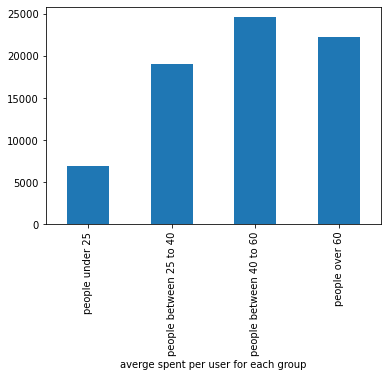

In [16]:
users_receipt=pd.merge(receipts,users_copy,left_on="USER_ID",right_on="ID",how="left")
age_spent=users_receipt.groupby("AGEGROUP").sum()["TOTAL_SPENT"]/users_copy["AGEGROUP"].value_counts()
age_spent.plot(kind="bar",xlabel="averge spent per user for each group")

From the graph, we can clearly see that young people spend much less than other groups.

### How many items users purchase for each month?

<AxesSubplot:xlabel='PURCHASE_MONTH'>

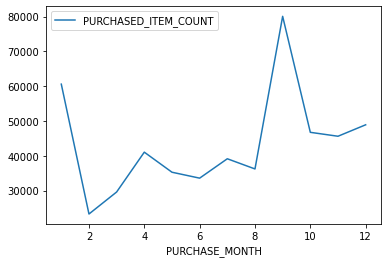

In [17]:
users_receipt["PURCHASE_MONTH"]=users_receipt["PURCHASE_DATE"].dt.month
users_receipt.groupby("PURCHASE_MONTH").sum().reset_index().plot.line(x="PURCHASE_MONTH",y="PURCHASED_ITEM_COUNT")


From graph, January and Sepetmeber are two monthes that people tend to have more purchase. 



### Did number of receipts scanned to the Fetch Rewards increases in 2022? 

<AxesSubplot:xlabel='receipts_scanned_numbers'>

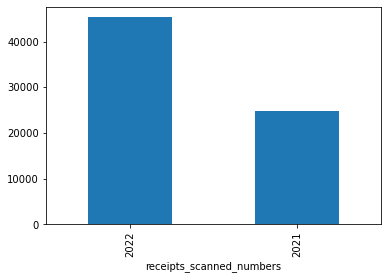

In [18]:
#merge receipts and users table in Pandas
users_receipt["SCANNED_YEAR"]=users_receipt["DATE_SCANNED"].dt.year
users_receipt["SCANNED_YEAR"].value_counts()[:2].plot(kind="bar",xlabel="receipts_scanned_numbers")

The number of increasing scans doubles from 2021 to 2022. 

Lastly, I am interested in which stores users consume more, and maybe we can do more business collaboration with them. 

<AxesSubplot:>

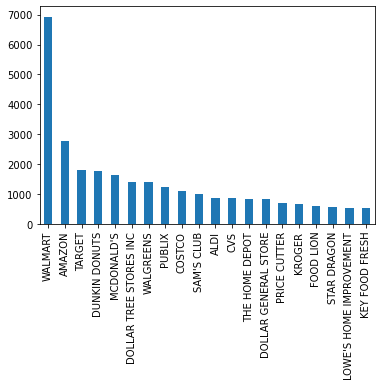

In [19]:
receipts["STORE_NAME"].value_counts()[:20].plot(kind="bar")

The figure above shows top 20 stores that on receipts users scanned. For future direction, I may focus on if these companies are cooperated with us. 